# Malicious URL Detection


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Load Dataset

In [3]:
df=pd.read_csv('url.csv')
print(df.head())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


## Remove rows where 'url' is missing

In [4]:
df.dropna(subset=['url']) 

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [5]:
df['label']=df['type'].apply(lambda t:0 if t=='benign' else 1)

## Extract Features from URLs

In [6]:
from urllib.parse import urlparse
def extract_features(url):
    parsed = urlparse(url)
    hostname = parsed.netloc
    path = parsed.path
    
    suspicious_keywords = ['secure', 'account', 'update', 'login', 'bank', 'verify', 'password']
    shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co', 'is.gd']

    features = {
        'url_length': len(url),
        'hostname_length': len(hostname),
        'count_dots': url.count('.'),
        'count_hyphens': url.count('-'),
        'count_at': url.count('@'),
        'count_question': url.count('?'),
        'count_equal': url.count('='),
        'count_http': url.count('http'),
        'count_https': url.count('https'),
        'count_www': url.count('www'),
        'count_digits': sum(c.isdigit() for c in url),
        'has_ip': 1 if re.search(r'\d+\.\d+\.\d+\.\d+', hostname) else 0,
        'https': 1 if parsed.scheme == 'https' else 0,
        'suspicious_words': sum(1 for word in suspicious_keywords if word in url.lower()),
        'is_shortened': 1 if any(short in hostname for short in shorteners) else 0,
        'count_slashes': url.count('/'),
        'count_percent': url.count('%'),
        'count_exclamation': url.count('!'),
        'count_tilde': url.count('~'),
        'count_star': url.count('*'),
        'count_colon': url.count(':'),
        'count_semicolon': url.count(';'),
        'count_comma': url.count(','),
        'count_plus': url.count('+'),
        'count_space': url.count('%20') + url.count(' '),
        'has_redirect': 1 if '//' in path else 0,
        'top_level_domain_length': len(hostname.split('.')[-1]) if '.' in hostname else 0,
        'count_subdomains': len(hostname.split('.')) - 2
    }
    return features

## Apply the feature extraction to all URLs

In [7]:
feature_list = df['url'].apply(extract_features)

In [8]:
features_df = pd.DataFrame(feature_list.tolist())
print(features_df.head())

   url_length  hostname_length  count_dots  count_hyphens  count_at  \
0          16                0           2              1         0   
1          35                0           2              0         0   
2          31                0           2              0         0   
3          88               21           3              1         0   
4         235               23           2              1         0   

   count_question  count_equal  count_http  count_https  count_www  ...  \
0               0            0           0            0          0  ...   
1               0            0           0            0          0  ...   
2               0            0           0            0          0  ...   
3               1            4           1            0          1  ...   
4               1            3           1            0          0  ...   

   count_tilde  count_star  count_colon  count_semicolon  count_comma  \
0            0           0            0          

In [9]:
# Combine original DataFrame with new features
print(df.columns)
df_combined = pd.concat([features_df,df['label']], axis=1)

Index(['url', 'type', 'label'], dtype='object')


In [10]:
df = df.dropna(subset=['label'])

In [11]:
#Define X (features) and y (label)
x = df_combined.drop(['label'], axis=1)
y=df_combined['label']

# Split dataset into Training and Testing
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3,random_state=42)

In [12]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate the model

In [13]:
y_pred=model.predict(x_test)
print("Accuracy:", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9710582622672222
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    128733
           1       0.97      0.94      0.96     66625

    accuracy                           0.97    195358
   macro avg       0.97      0.96      0.97    195358
weighted avg       0.97      0.97      0.97    195358



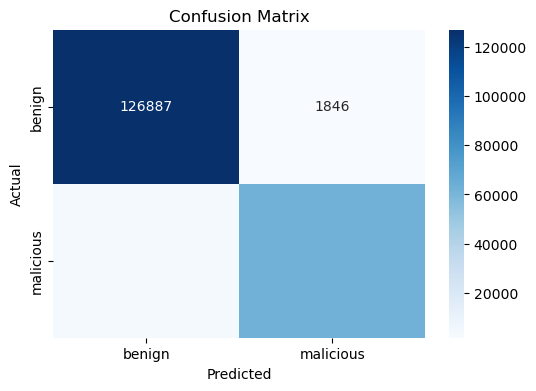

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix= confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=['benign','malicious'],yticklabels=['benign','malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

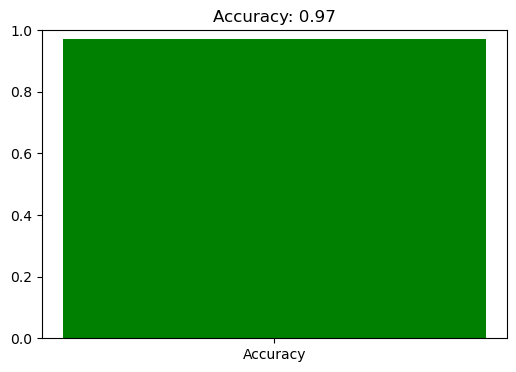

In [15]:
accuracy=accuracy_score(y_test,y_pred)
plt.figure(figsize=(6,4))
plt.bar(['Accuracy'],[accuracy],color='green')
plt.ylim(0,1)
plt.title(f'Accuracy: {accuracy:.2f}')
plt.show()

In [16]:
print(df.shape)
print(df.head(1000))

(651191, 3)
                                                   url        type  label
0                                     br-icloud.com.br    phishing      1
1                  mp3raid.com/music/krizz_kaliko.html      benign      0
2                      bopsecrets.org/rexroth/cr/1.htm      benign      0
3    http://www.garage-pirenne.be/index.php?option=...  defacement      1
4    http://adventure-nicaragua.net/index.php?optio...  defacement      1
..                                                 ...         ...    ...
995                    youtube.com/watch?v=EcGsM-PNQHQ      benign      0
996  bloomberg.com/news/2011-08-28/dust-bowl-in-tex...      benign      0
997                          http://www.slavia.sk/home  defacement      1
998                               innerearbrigade.com/      benign      0
999                                   brokenbells.com/      benign      0

[1000 rows x 3 columns]


In [17]:
TN=conf_matrix[0,0]
FP=conf_matrix[0,1]
FN=conf_matrix[1,0]
TP=conf_matrix[1,1]
print(FN+TP,TP,TN)

66625 62817 126887


In [18]:
b=df_combined['label'].value_counts()[0]
m=df_combined['label'].value_counts()[1]
print(b,m)

428103 223088


In [20]:
import pickle
with open('url_model.pkl','wb') as f:
    pickle.dump(model,f)
print("Model trained and saved successfully!")

Model trained and saved successfully!
